In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

In [2]:
stat = pd.read_csv('../keyhistory.csv') # data to read
stat["time"] = (pd.to_datetime(stat["time"], unit = 's'))

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
# TODO:
#
# интегральный график того сколько раз нажимал кнопку каждую
# типа например кнопка А - 8 числа 500 нажатий, затем 9 числа еще 500 нажатий, 
# на графике 8 числа - 500, 9 числа - 1к
# ------------------------------------
# логгинг мыши с перспективой получения heatmap кликов 

In [3]:
# HERLPER METHODS

def IsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def InputParser(string):
    words = string.split()
    for i in range(len(words)):
        if IsInt(words[i]):
            number = int(words[i])
        else:
            chars = words[i]
    return (number, chars)
  
def UseBetterDelta(time, numb, period):
    if (period == 'months' or period == "month" or period == "M" or period == "m"):
        return time+relativedelta(months=+numb)
    if (period == "weeks" or period == "week" or period == "W" or period == "w"):
        return time+relativedelta(weeks=+numb)
    
def IsTime(first, second):
    fir = list(first); sec = list(second)
    if (len(fir) > 2) & (len(sec) > 2 ):
        if (fir[2] == ":" or fir[1] == ":") & (sec[2] == ":" or sec[1] == ":"):
            return True
    return False

In [4]:
def EveryStroke(start = "0", offset = "0", startTime = "0", endTime = "0"):
    """клавиши и соответствующее им количество нажатий за все время или за промежуток
       если оба аргумента передаются как xx:xx, то промежуток берется каждый день 
       между этими двумя часами. при этом можно взять календарный промежуток, 
       и еще в нем между двумя часами"""
    # здесь, кстати, не возникает проблемы как в InPeriod с обрезанием последней записи
    if (IsTime(start, offset)):
            return stat.set_index('time').between_time(start, offset).reset_index().key.value_counts()
    
    if (start != "0") & (offset != "0"):
        start_date = pd.Timestamp(start)
        # из-за того что пандасовская timedelta не умеет работать
        # с неделями и месяцами, приходится идти на хитрости
        try:
            end_date = start_date + pd.Timedelta(offset)
        except ValueError:
            end_date = UseBetterDelta(start_date, *InputParser(offset))
        betweenDates = stat.loc[stat.time.between(start_date, end_date)]
        if (IsTime(startTime, endTime)):
            return betweenDates.set_index('time').between_time(startTime, endTime).reset_index().key.value_counts()
        else:
            return betweenDates.key.value_counts()
    return stat.key.value_counts()

def PiePlot(data):
    """Представить данные о нажатиях всех клавиш в виде pie-чарта"""
    # получаем данные для визуализации
    indexes = data.index.to_numpy()
    values = data.to_numpy()
    
    # прячем лишние элементы в other, что бы суммарно было 20 элементов + other
    other_values = values[20:len(values)]
    values = np.delete(values, range(20, len(values)))
    values = np.append(values, other_values.sum())
    indexes = np.delete(indexes, range(20, len(indexes)))
    indexes = np.append(indexes, "Other")
    
    percent = 100.*values/values.sum()
    patches, texts = plt.pie(values, startangle=90, radius=2, 
                             colors = ['#e6194B', '#f58231', '#ffe119', '#bfef45',
                                       '#3cb44b', '#42d4f4', '#4363d8', '#911eb4', '#f032e6',
                                       '#fabed4', '#ffd8b1', '#fffac8', '#aaffc3', '#dcbeff',
                                       'lightcyan', 'lightblue', 'lightpink', 'beige', 
                                       'lightsteelblue', 'slategrey', '#a9a9a9'])
    
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(indexes, percent)]
    plt.legend(patches, labels, loc='center right', bbox_to_anchor=(2.2, 0.5),
               fontsize=11)
    plt.show()

    
def KeyStroke(key):
    """получить нажатия определенной клавиши за всё время"""
    if key not in stat.key.drop_duplicates().tolist():
        return 0
    return stat.groupby(by='key').get_group(key)

def SplitStrokes(scale = "d", data = stat, allowEmpty = True):
    """число нажатий (по умолчанию - всех клавиш) за всё время, 
                                            разбитое на промежутки, см. scale
    может считать нажатия отдельно взятой клавиши, см. аргумент data
    может убирать пустые вхождения, см. аргумент allowEmpty"""
    resampled = data.resample(scale, on='time').size()
    if (not allowEmpty):
        return resampled[resampled != 0]
    return resampled

def InPeriod(data, start, offset):
    """ограничить интервал данных промежутком от старта до старта+оффсета"""
    # объяснение, зачем обрезать последнюю запись: 
    # 01:00 соответствует интервалу с 01:00 до 02:00, тогда если мы претендуем
    # дать данные за 2 часа, и мы начинаем с 3 часов ночи то мы должны давать 
    # записи 03:00 и 04:00 (это будет интервал 03:00-04:00 и 04:00-05:00, т.е 2 часа)
    # но пандас по умолчанию при индексировании включает как первую, так и последнюю
    # запись. то есть, взяв 03:00 и 2 hours, мы бы получили записи 03:00, 04:00 и 05:00
    # а это уже не 2 часа, а 3
    start_date = pd.Timestamp(start)
    end_date = start_date + pd.Timedelta(offset)
    return data[start_date : end_date].iloc[:-1] # обрезаем последнюю запись

def Average(period):
    """среднее число нажатий за данный период"""
    return period.mean()

In [8]:
print("Среднее число нажатий любых клавиш в час за всё время:",
      Average(SplitStrokes("h")))
print("Среднее число нажатий клавиши A в час за всё время:",
     Average(SplitStrokes('h', KeyStroke("A"))))
print("Среднее число нажатий любых клавиш за 2 часа 12/08/20 между 11 и 13 часами:",
     Average(InPeriod(SplitStrokes('h'), "2020-08-12 11:00:00", "2 hours")))

print("Число нажатий клавиши A, разбитое на промежутки по часу:\n",
     SplitStrokes('h', KeyStroke("A")), "\n")
print("Число нажатий клавиши A, разбитое по часам и без пустых интервалов:\n",
     SplitStrokes('h', KeyStroke("A"), False), "\n")
print("Нажатия всех клавиш, разбитые по неделям:\n",
     SplitStrokes(scale='w'),"\n")

print("Число нажатий каждый день между 00:00 и 02:00:\n",
      EveryStroke("0:00", "2:00"),"\n")
print("Число нажатий каждый день между 10:00 и 18:00 в период с 1 сентября до 31 мая:\n",
      EveryStroke("2020-09-01", "9 months", "10:00", "18:00"),"\n")
print("Число нажатий клавиш за 3 часа 12/08/20 между 13 и 16 часами:\n",
     EveryStroke("2020-08-12 13:00:00", "3 hours"),"\n")

Среднее число нажатий любых клавиш в час за всё время: 3010.4444444444443
Среднее число нажатий клавиши A в час за всё время: 87.11111111111111
Среднее число нажатий любых клавиш за 2 часа 12/08/20 между 11 и 13 часами: 967.0
Число нажатий клавиши A, разбитое на промежутки по часу:
 time
2020-08-12 10:00:00      3
2020-08-12 11:00:00      0
2020-08-12 12:00:00     62
2020-08-12 13:00:00    152
2020-08-12 14:00:00    190
2020-08-12 15:00:00    179
2020-08-12 16:00:00     97
2020-08-12 17:00:00     77
2020-08-12 18:00:00     24
Freq: H, dtype: int64 

Число нажатий клавиши A, разбитое по часам и без пустых интервалов:
 time
2020-08-12 10:00:00      3
2020-08-12 12:00:00     62
2020-08-12 13:00:00    152
2020-08-12 14:00:00    190
2020-08-12 15:00:00    179
2020-08-12 16:00:00     97
2020-08-12 17:00:00     77
2020-08-12 18:00:00     24
dtype: int64 

Нажатия всех клавиш, разбитые по неделям:
 time
2020-08-16    27094
Freq: W-SUN, dtype: int64
Число нажатий каждый день между 00:00 и 02:00

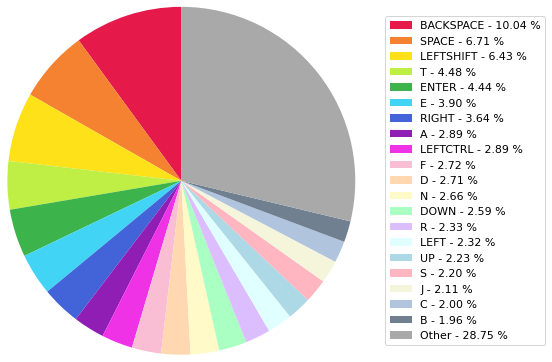

In [6]:
PiePlot(EveryStroke())